In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import laspy
import os
import time


In [ ]:
# 读取数据
data = np.loadtxt('../../data/bridge-5cls-fukushima/raw/Bridge1.txt', delimiter=' ')

# 提取床板数据（label == 2）
deck_data = data[data[:, 6] == 2]

# 提取x, y坐标（忽略z坐标）
deck_coords = deck_data[:, :2]

print(f"Total points: {data.shape[0]}")
print(f"Deck points: {deck_data.shape[0]}")


Estimated bridge length (PCA): 6.33
Estimated bridge width (PCA): 5.71
PCA time taken: 0.06 seconds


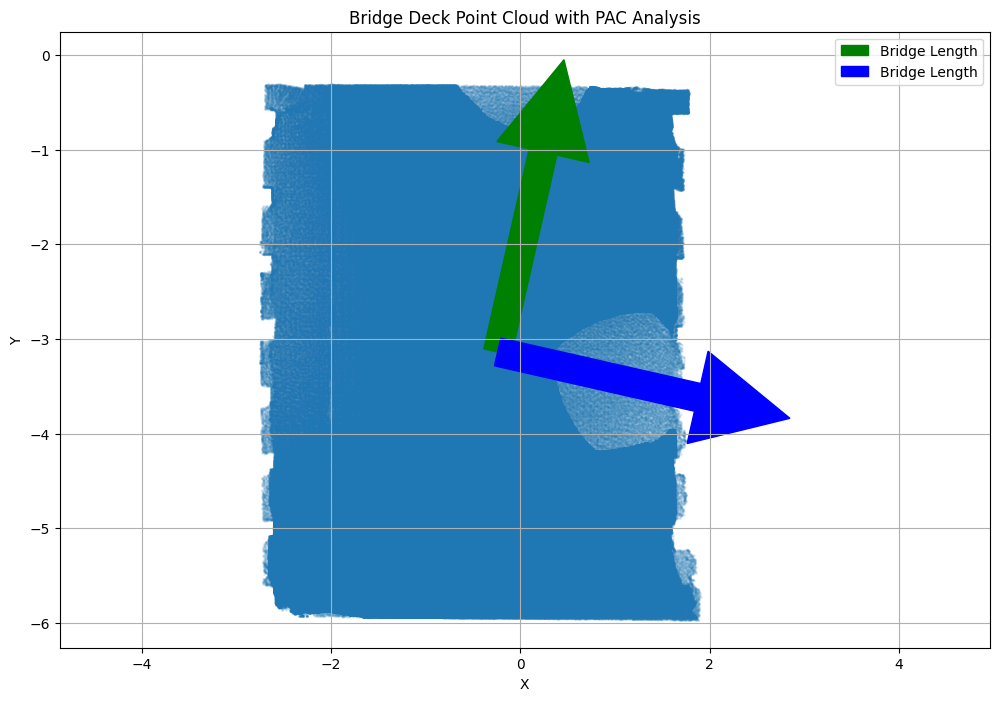

In [46]:
# 使用PCA方法进行比较
from sklearn.decomposition import PCA

pca_start_time = time.time()

pca = PCA(n_components=2)
pca.fit(deck_coords)

# 将数据投影到主成分上
projected_data = pca.transform(deck_coords)

# 计算PCA方法的长度和宽度
pca_length = np.max(projected_data[:, 0]) - np.min(projected_data[:, 0])
pca_width = np.max(projected_data[:, 1]) - np.min(projected_data[:, 1])

pca_end_time = time.time()

print(f"Estimated bridge length (PCA): {pca_length:.2f}")
print(f"Estimated bridge width (PCA): {pca_width:.2f}")
print(f"PCA time taken: {pca_end_time - pca_start_time:.2f} seconds")

# 可视化
plt.figure(figsize=(12, 8))
plt.scatter(deck_coords[:, 0], deck_coords[:, 1], alpha=0.1, s=1)
plt.title('Bridge Deck (Top View)')
plt.xlabel('X')
plt.ylabel('Y')

# 绘制主方向
mean = np.mean(deck_coords, axis=0)
eigen_vec = pca.components_[0]
eigen_vec = eigen_vec * pca_length / 2  # 缩放箭头长度

eigen_vec2 = pca.components_[1]
eigen_vec2 = eigen_vec2 * pca_length / 2  # 缩放箭头长度

plt.arrow(mean[0], mean[1], eigen_vec[0], eigen_vec[1], 
          color='g', width=0.3, head_width=1, head_length=1, 
          length_includes_head=True, label='Bridge Length')

plt.arrow(mean[0], mean[1], eigen_vec2[0], eigen_vec2[1], 
          color='b', width=0.3, head_width=1, head_length=1, 
          length_includes_head=True, label='Bridge Length')


plt.title('Bridge Deck Point Cloud with PAC Analysis')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

In [40]:
# 计算点云的协方差矩阵
cov_matrix = np.cov(deck_coords.T)

# 计算协方差矩阵的特征值和特征向量
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# 找到最大特征值对应的特征向量
max_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]

# 将所有点投影到这个方向上
projections = np.dot(deck_coords, max_eigenvector)

# 计算投影的最大和最小值之差作为桥长
bridge_length = np.max(projections) - np.min(projections)

# 计算垂直于主方向的向量
perpendicular_vector = np.array([-max_eigenvector[1], max_eigenvector[0]])

# 将所有点投影到垂直方向上
perp_projections = np.dot(deck_coords, perpendicular_vector)

# 计算垂直投影的最大和最小值之差作为桥宽
bridge_width = np.max(perp_projections) - np.min(perp_projections)

print(f"Estimated bridge length (Covariance): {bridge_length:.2f}")
print(f"Estimated bridge width (Covariance): {bridge_width:.2f}")

Estimated bridge length (Covariance): 6.33
Estimated bridge width (Covariance): 5.71


In [41]:
# 计算边界框
min_coords = np.min(deck_coords, axis=0)
max_coords = np.max(deck_coords, axis=0)

# 计算对角线长度（作为桥长的估计）
diagonal_length = np.linalg.norm(max_coords - min_coords)

# 计算边界框的宽度和长度
width = max_coords[1] - min_coords[1]
length = max_coords[0] - min_coords[0]

print(f"Estimated bridge length (diagonal): {diagonal_length:.2f}")
print(f"Estimated bridge length (bounding box): {length:.2f}")
print(f"Estimated bridge width (bounding box): {width:.2f}")

Estimated bridge length (diagonal): 7.33
Estimated bridge length (bounding box): 4.66
Estimated bridge width (bounding box): 5.66


Estimated bridge length (RANSAC): 5.66
Estimated bridge width (RANSAC): 4.66
Time taken: 0.31 seconds


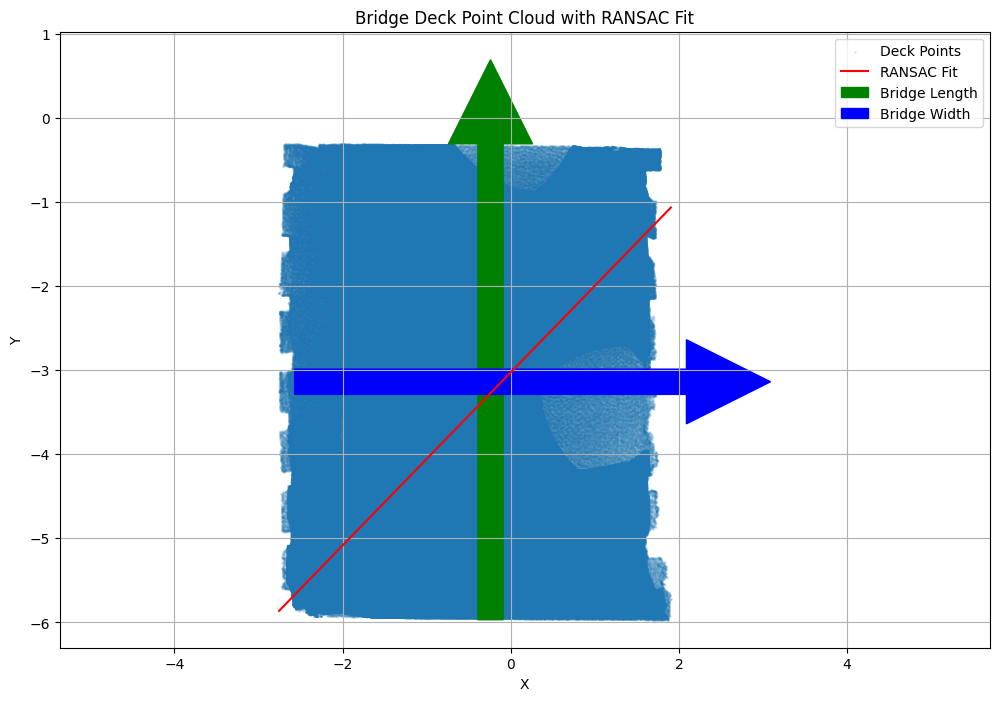

In [47]:
from sklearn.linear_model import RANSACRegressor
import time

start_time = time.time()


# 使用RANSAC拟合直线
ransac = RANSACRegressor()
ransac.fit(deck_coords[:, 0].reshape(-1, 1), deck_coords[:, 1])

# 获取RANSAC模型的方向向量
slope = ransac.estimator_.coef_[0]
angle = np.arctan(slope)

# 判断主方向是更接近X轴还是Y轴
if abs(angle) < np.pi/4:  # 更接近X轴
    direction_vector = np.array([1, 0])
    perpendicular_vector = np.array([0, 1])
else:  # 更接近Y轴
    direction_vector = np.array([0, 1])
    perpendicular_vector = np.array([1, 0])

# 将所有点投影到主方向上
projections = np.dot(deck_coords, direction_vector)

# 计算桥长（投影的最大和最小值之差）
bridge_length = np.max(projections) - np.min(projections)

# 将所有点投影到垂直方向上
perp_projections = np.dot(deck_coords, perpendicular_vector)

# 计算桥宽（垂直投影的最大和最小值之差）
bridge_width = np.max(perp_projections) - np.min(perp_projections)

end_time = time.time()

print(f"Estimated bridge length (RANSAC): {bridge_length:.2f}")
print(f"Estimated bridge width (RANSAC): {bridge_width:.2f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")


# 可视化
plt.figure(figsize=(12, 8))
plt.scatter(deck_coords[:, 0], deck_coords[:, 1], s=1, alpha=0.1, label='Deck Points')

# 计算RANSAC直线的端点
x_min, x_max = np.min(deck_coords[:, 0]), np.max(deck_coords[:, 0])
y_min = ransac.predict([[x_min]])[0]
y_max = ransac.predict([[x_max]])[0]

# 绘制RANSAC拟合的直线
plt.plot([x_min, x_max], [y_min, y_max], 'r-', label='RANSAC Fit')

# 计算桥长和桥宽的端点
center = np.mean(deck_coords, axis=0)
length_vector = direction_vector * bridge_length / 2
width_vector = perpendicular_vector * bridge_width / 2

# 绘制桥长
plt.arrow(center[0] - length_vector[0], center[1] - length_vector[1],
          length_vector[0] * 2, length_vector[1] * 2,
          color='g', width=0.3, head_width=1, head_length=1, label='Bridge Length')

# 绘制桥宽
plt.arrow(center[0] - width_vector[0], center[1] - width_vector[1],
          width_vector[0] * 2, width_vector[1] * 2,
          color='b', width=0.3, head_width=1, head_length=1, label='Bridge Width')

plt.title('Bridge Deck Point Cloud with RANSAC Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)

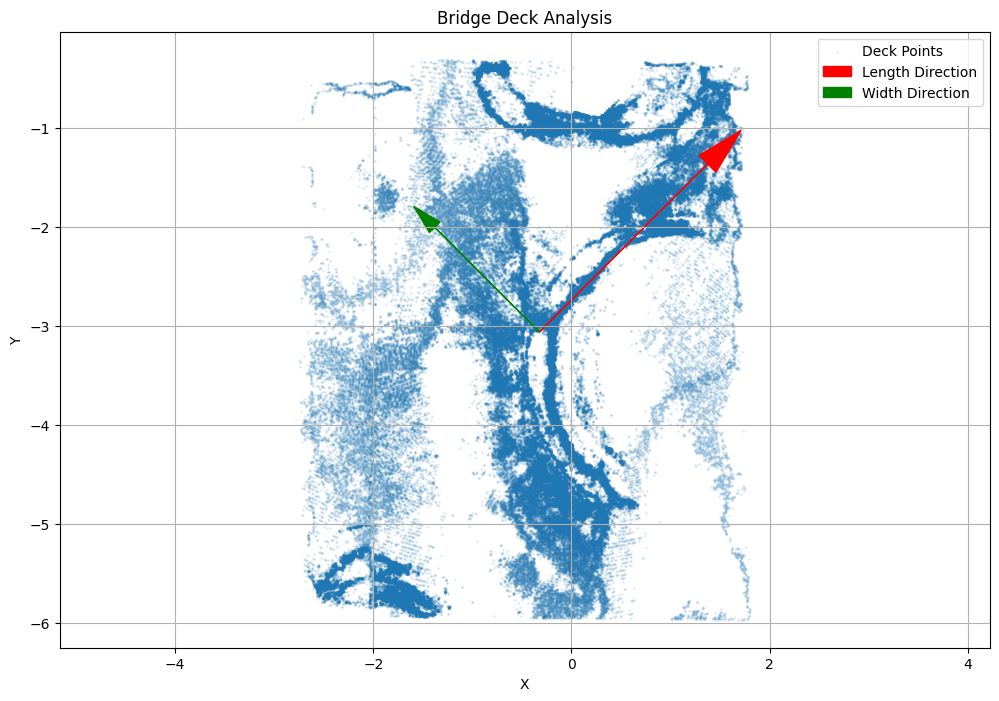

Estimated bridge length: 4.80
Estimated bridge width: 2.99


Estimated bridge length: 5.49
Estimated bridge width: 4.19
Time taken: 0.47 seconds


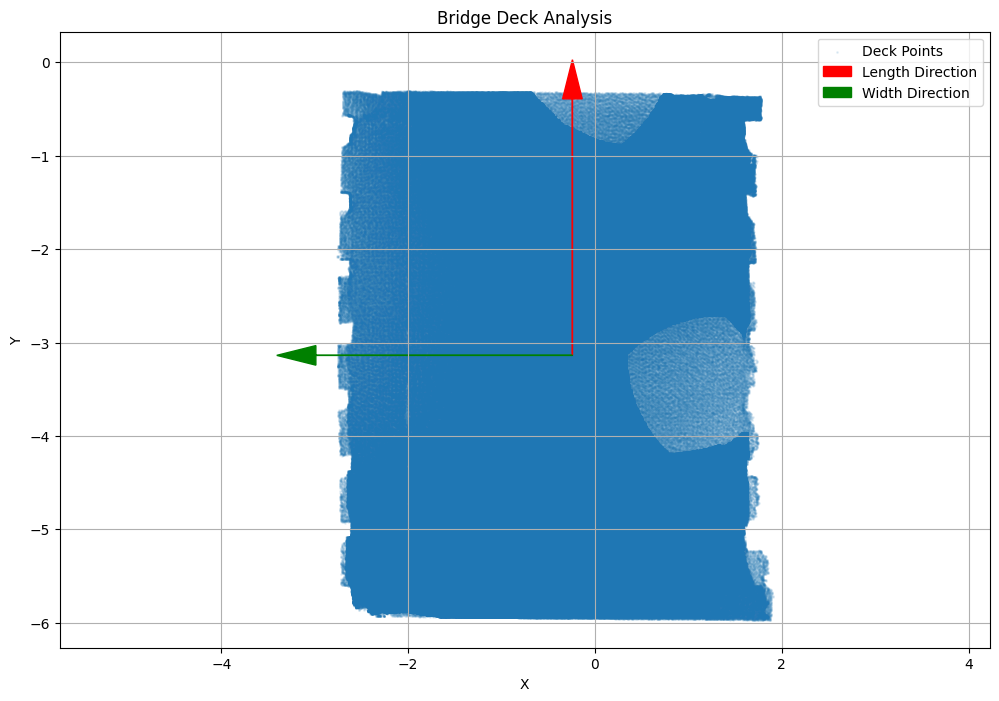

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

def calculate_bridge_dimensions(deck_coords):
    start_time = time.time()
    # 步骤1: 使用椭圆包络去除离群值
    #outlier_detector = EllipticEnvelope(contamination=0.1, random_state=42)
    #inlier_mask = outlier_detector.fit_predict(deck_coords) == 1
    filtered_coords = deck_coords
    

    # 步骤2: 使用PCA进行初步方向估计
    pca = PCA(n_components=2)
    pca.fit(filtered_coords)
    
    # 步骤3: 使用RANSAC拟合主方向
    ransac = RANSACRegressor(random_state=42)
    x = filtered_coords[:, 0].reshape(-1, 1)
    y = filtered_coords[:, 1]
    ransac.fit(x, y)
    
    # 步骤4: 计算主方向向量
    angle = np.arctan(ransac.estimator_.coef_[0])
    main_direction = np.array([np.cos(angle), np.sin(angle)])
    
    # 步骤5: 确保主方向更接近x轴或y轴
    if abs(main_direction[0]) < abs(main_direction[1]):
        main_direction = np.array([0, 1])
    else:
        main_direction = np.array([1, 0])
    
    # 步骤6: 计算垂直方向
    perpendicular_direction = np.array([-main_direction[1], main_direction[0]])
    
    # 步骤7: 计算桥长和桥宽
    projections_main = np.dot(filtered_coords, main_direction)
    projections_perp = np.dot(filtered_coords, perpendicular_direction)
    
    bridge_length = np.percentile(projections_main, 99) - np.percentile(projections_main, 1)
    bridge_width = np.percentile(projections_perp, 99) - np.percentile(projections_perp, 1)
    
    end_time = time.time()
    
    time_taken = end_time - start_time
    
    return bridge_length, bridge_width, main_direction, perpendicular_direction, filtered_coords, time_taken

# 假设deck_coords是一个numpy数组，形状为(n, 2)
bridge_length, bridge_width, main_direction, perpendicular_direction, filtered_coords, time_taken = calculate_bridge_dimensions(deck_coords)

print(f"Estimated bridge length: {bridge_length:.2f}")
print(f"Estimated bridge width: {bridge_width:.2f}")
print(f"Time taken: {time_taken:.2f} seconds")

# 可视化结果
plt.figure(figsize=(12, 8))
plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], s=1, alpha=0.1, label='Deck Points')

# 绘制主方向和垂直方向
mean = np.mean(filtered_coords, axis=0)
for direction, color, label in zip([main_direction, perpendicular_direction], ['r', 'g'], ['Length', 'Width']):
    plt.arrow(mean[0], mean[1], direction[0]*bridge_length/2, direction[1]*bridge_length/2, 
              color=color, head_width=bridge_width/20, head_length=bridge_width/10, 
              label=f"{label} Direction")

plt.title('Bridge Deck Analysis')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


